In [ ]:
from AgriEnv5x4_3agents import AgriEnv
import traceback
import random
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import numpy as np
import random
from collections import deque
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
import cv2
import pickle

pygame 2.6.1 (SDL 2.28.4, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


In [ ]:
# Defining Actor Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        
        # Shared layers
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)

        # Actor: Outputs action probabilities
        self.actor_fc = nn.Linear(128, action_size)
        
        # Critic: Outputs state value
        self.critic_fc = nn.Linear(128, 1)
        
    def forward(self, state):
        # Forward pass through shared layers
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        # Actor and Critic heads
        action_probs = torch.softmax(self.actor_fc(x), dim=-1)
        state_value = self.critic_fc(x)
        
        return action_probs, state_value

In [ ]:
# Defining Advantage Actor Critic Agent (A2C)
class A2CAgent:
    def __init__(self, state_size, action_size, device, learning_rate=0.0005):
        self.device = device
        self.actor_critic = ActorCritic(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=learning_rate)
        # Discount factor for rewards
        self.gamma = 0.90
        self.actor_loss_vals = []
        self.critic_loss_vals = []
        self.entropy_loss_vals = []
        self.loss_vals = []

    def get_action(self, state):
        """  Computes an action for the agent given the current state."""

        # Convert the state to a PyTorch tensor, add a batch dimension, and move to the appropriate device
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        # Pass the state through the actor-critic network to get action probabilities and value estimates
        action_probs, _ = self.actor_critic(state)
        # Create a categorical distribution using the action probabilities
        dist = torch.distributions.Categorical(action_probs)
        # Sample an action from the probability distribution
        action = dist.sample()
        # Clamp the action is within valid bounds
        action = action.clamp(min=0, max=dist.probs.shape[-1] - 1)
        # Return the selected action and its log probability
        return action.item(), dist.log_prob(action)

    def learn(self, states, actions, rewards, next_states, dones):
        """
        Updates both the actor and critic networks.
        """
        # Convert inputs to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).squeeze(1).to(self.device)

        # Get current and next state values from the critic
        action_probs, values = self.actor_critic(states)
        _, next_values = self.actor_critic(next_states)

        # Calculate target values (Bellman equation)
        target = rewards + self.gamma * next_values.squeeze(1) * (1 - dones)
        
        # Calculate advantages
        target = target.squeeze()
        advantages = target - values.squeeze(1)

        # Normalize advantages for stability)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Calculate Critic Loss (Value Loss)
        critic_loss = F.mse_loss(values.squeeze(1), target)

        # Calculate Actor Loss (Policy Loss)
        dist = torch.distributions.Categorical(action_probs)
        action_log_probs = dist.log_prob(actions)
        actor_loss = -(action_log_probs * advantages.detach()).mean()

        # Entropy loss to encourage exploration
        entropy_loss = dist.entropy().mean()

        # Total Loss
        loss = actor_loss + 0.8 * critic_loss - 0.6 * entropy_loss  # 0.01 is the entropy coefficient
        self.actor_loss_vals.append(actor_loss)
        self.critic_loss_vals.append(critic_loss)
        self.entropy_loss_vals.append(entropy_loss)
        self.loss_vals.append(loss)

        # Update networks
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self, filepath):
        """ Save the actor-critic network weights"""

        torch.save(self.actor_critic.state_dict(), filepath)

    def load(self, filepath):
        
        """ Load the actor-critic network weights"""
        self.actor_critic.load_state_dict(torch.load(filepath))


In [ ]:
# Initialize Cuda device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize RL environment AgriEnv
agri_env = AgriEnv() 

In [6]:
print(agri_env.observation_space[0].shape[0])
print(agri_env.observation_space[1].shape[0])
print(agri_env.observation_space[2].shape[0])
print(agri_env.observation_space[3].shape[0])

36
3
2
3


In [ ]:
plot_state_size = agri_env.observation_space[0].shape[0]
seeder_state_size = agri_env.observation_space[1].shape[0]
waterer_state_size = agri_env.observation_space[2].shape[0]
harvester_state_size = agri_env.observation_space[3].shape[0]


# Create three separate A2C agents for the seeder and harvester
seeder_agent = A2CAgent(state_size=plot_state_size + seeder_state_size, action_size=agri_env.action_space['seeder_agent'].n, device=device)
water_agent = A2CAgent(state_size=plot_state_size + waterer_state_size, action_size=agri_env.action_space['water_agent'].n, device=device)
harvester_agent = A2CAgent(state_size=plot_state_size + harvester_state_size, action_size=agri_env.action_space['harvester_agent'].n, device=device)
 

In [8]:
seeder_rewards = []
harvester_rewards = []
water_rewards = []
game_scores = []

best_score = 0
save_video = False

In [9]:
num_episodes = 20000

In [ ]:
# with open("a2c_5x4_3agents/rewards_data.pkl", "rb") as f:
#     rewards_data = pickle.load(f)

# # Extract individual rewards lists
# seeder_rewards = rewards_data["seeder_rewards"]
# harvester_rewards = rewards_data["harvester_rewards"]
# water_rewards = rewards_data["water_rewards"]
# game_scores = rewards_data["game_scores"]

# seeder_agent.load("a2c_5x4_3agents/seeder_a2c.pkl")
# harvester_agent.load("a2c_5x4_3agents/harvester_a2c.pkl")
# water_agent.load("a2c_5x4_3agents/water_a2c.pkl")

In [11]:
old_count = len(harvester_rewards)
print(old_count)

40000


In [ ]:
with tqdm(total=old_count+num_episodes, initial=old_count, desc="Training Episodes", unit="episode") as pbar:
    for episode in range(old_count, old_count+num_episodes):
        if (episode + 1)%500 == 0:
            save_video = True
        
        if save_video:
            video_filename = f"a2c_5x4_3agents/episode_{episode+1}.mp4"
            # Initialize VideoWriter
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            video_writer = None

        state, _ = agri_env.reset()  # Reset environment for each episode
        done = False
        episode_rewards_seeder = 0
        episode_rewards_harvester = 0
        episode_rewards_water = 0
        
        # Store information for learning
        states, actions, rewards, next_states, dones = [], [], [], [], []

        # Create a progress bar for steps within the episode using `with tqdm`
        while not done:
            # Construct state for both agents
            seeder_state = state[0] + state[1]
            water_state = state[0] + state[2]
            harvester_state = state[0] + state[3]
            # print("seeder_state", seeder_state)
            # print("harvester_state", harvester_state)
            
            # Get actions and log probabilities for both agents
            seeder_action, seeder_log_prob = seeder_agent.get_action(seeder_state)
            water_action, water_log_prob = water_agent.get_action(water_state)
            harvester_action, harvester_log_prob = harvester_agent.get_action(harvester_state)

            # Take actions in the environment
            next_state, reward, done, _ = agri_env.step({
                'seeder_agent': seeder_action,
                'harvester_agent': harvester_action,
                'water_agent': water_action
            })

            next_seeder_state = next_state[0] + next_state[1]  # Update seeder agent's next state
            next_water_state = next_state[0] + next_state[2]
            next_harvester_state = next_state[0] + next_state[3]

            # Store the information for both agents (states, actions, rewards)
            states.append([seeder_state, water_state,  harvester_state])
            actions.append([seeder_action, water_action, harvester_action])
            rewards.append([reward['seeder_agent'], reward['water_agent'], reward['harvester_agent']])
            
            next_states.append([next_seeder_state, next_water_state, next_harvester_state])  # Combined next states
            dones.append([done])

            if save_video:
                frame = agri_env.render()
                # Convert frame from RGB (Pygame format) to BGR (OpenCV format)
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                # Initialize the video writer with frame dimensions on first frame
                if video_writer is None:
                    height, width, _ = frame.shape
                    video_writer = cv2.VideoWriter(video_filename, fourcc, 30, (width, height))
                # Write frame to video
                video_writer.write(frame)

            # Update episode rewards
            episode_rewards_seeder += reward['seeder_agent']
            episode_rewards_water += reward['water_agent']
            episode_rewards_harvester += reward['harvester_agent']

            # Update state
            state = next_state

        # After the episode ends, train both agents
        # Train both agents
        seeder_agent.learn([state[0] for state in states], [action[0] for action in actions], [reward[0] for reward in rewards], [next_state[0] for next_state in next_states], dones)
        water_agent.learn([state[1] for state in states], [action[1] for action in actions], [reward[1] for reward in rewards], [next_states[1] for next_states in next_states], dones)
        harvester_agent.learn([state[2] for state in states], [action[2] for action in actions], [reward[2] for reward in rewards], [next_states[2] for next_states in next_states], dones)
        
        # Update progress bar postfix with current rewards
        pbar.set_postfix({'Seeder Reward': episode_rewards_seeder,'Water Reward': episode_rewards_water,'Harvester Reward': episode_rewards_harvester, 'Game Score':agri_env.game_score})
        
        # Update the outer progress bar for each episode
        pbar.update(1)

        if save_video:
            if video_writer is not None:
                video_writer.release()
    
            print(f"Video for episode {episode} saved as {video_filename}")
        save_video = False
        
        # Store the rewards for each episode in the list
        seeder_rewards.append(episode_rewards_seeder)
        water_rewards.append(episode_rewards_water)
        harvester_rewards.append(episode_rewards_harvester)
        game_scores.append(agri_env.game_score)
        
        if agri_env.game_score > best_score:
            best_score = agri_env.game_score
            seeder_agent.save(f"a2c_5x4_3agents/seeder_a2c_best.pkl",)
            water_agent.save(f"a2c_5x4_3agents/water_a2c_best.pkl")
            harvester_agent.save(f"a2c_5x4_3agents/harvester_a2c_best.pkl")

        if (episode+1)%500 == 0:
            seeder_agent.save(f"a2c_5x4_3agents/seeder_a2c.pkl",)
            water_agent.save(f"a2c_5x4_3agents/water_a2c.pkl")
            harvester_agent.save(f"a2c_5x4_3agents/harvester_a2c.pkl")
            rewards_data = {
                "seeder_rewards": seeder_rewards,
                "harvester_rewards": harvester_rewards,
                "water_rewards": water_rewards,
                "game_scores": game_scores
            }

            # Save the dictionary
            with open("a2c_5x4_3agents/rewards_data.pkl", "wb") as f:
                pickle.dump(rewards_data, f)
    

seeder_agent.save("a2c_5x4_3agents/seeder_agent_model.pkl")
water_agent.save("a2c_5x4_3agents/water_agent_model.pkl")
harvester_agent.save("a2c_5x4_3agents/harvester_agent_model.pkl")

print("Training Completed")

Training Episodes:   2%|▎         | 500/20000 [05:21<9:40:05,  1.78s/episode, Seeder Reward=-24.4, Water Reward=-18.7, Harvester Reward=21.2, Game Score=24] 

Video for episode 499 saved as a2c_3agents_rfmini/episode_500.mp4


Training Episodes:   5%|▌         | 1000/20000 [10:46<9:34:04,  1.81s/episode, Seeder Reward=-12.8, Water Reward=-17.8, Harvester Reward=28.4, Game Score=26]

Video for episode 999 saved as a2c_3agents_rfmini/episode_1000.mp4


Training Episodes:   8%|▊         | 1500/20000 [16:08<9:17:08,  1.81s/episode, Seeder Reward=-26.1, Water Reward=-20.2, Harvester Reward=11.4, Game Score=24] 

Video for episode 1499 saved as a2c_3agents_rfmini/episode_1500.mp4


Training Episodes:  10%|█         | 2000/20000 [21:31<9:02:36,  1.81s/episode, Seeder Reward=-3.24, Water Reward=-9.87, Harvester Reward=29.6, Game Score=24] 

Video for episode 1999 saved as a2c_3agents_rfmini/episode_2000.mp4


Training Episodes:  12%|█▎        | 2500/20000 [26:54<8:41:12,  1.79s/episode, Seeder Reward=-12.4, Water Reward=-2.36, Harvester Reward=29.8, Game Score=38] 

Video for episode 2499 saved as a2c_3agents_rfmini/episode_2500.mp4


Training Episodes:  15%|█▌        | 3000/20000 [32:18<8:12:09,  1.74s/episode, Seeder Reward=10.8, Water Reward=7.3, Harvester Reward=52.3, Game Score=44]    

Video for episode 2999 saved as a2c_3agents_rfmini/episode_3000.mp4


Training Episodes:  18%|█▊        | 3500/20000 [37:42<7:56:03,  1.73s/episode, Seeder Reward=-6.67, Water Reward=-10.6, Harvester Reward=18.6, Game Score=24]  

Video for episode 3499 saved as a2c_3agents_rfmini/episode_3500.mp4


Training Episodes:  20%|██        | 4000/20000 [43:06<7:47:24,  1.75s/episode, Seeder Reward=-18.6, Water Reward=-24.6, Harvester Reward=18.9, Game Score=24] 

Video for episode 3999 saved as a2c_3agents_rfmini/episode_4000.mp4


Training Episodes:  22%|██▎       | 4500/20000 [48:29<6:49:05,  1.58s/episode, Seeder Reward=-19.8, Water Reward=-27.3, Harvester Reward=10.1, Game Score=22] 

Video for episode 4499 saved as a2c_3agents_rfmini/episode_4500.mp4


Training Episodes:  25%|██▌       | 5000/20000 [53:53<7:16:22,  1.75s/episode, Seeder Reward=-20.1, Water Reward=-20.3, Harvester Reward=26.9, Game Score=26] 

Video for episode 4999 saved as a2c_3agents_rfmini/episode_5000.mp4


Training Episodes:  28%|██▊       | 5500/20000 [59:15<6:30:05,  1.61s/episode, Seeder Reward=-4.11, Water Reward=-7.36, Harvester Reward=52.3, Game Score=36] 

Video for episode 5499 saved as a2c_3agents_rfmini/episode_5500.mp4


Training Episodes:  30%|███       | 6000/20000 [1:04:37<6:11:21,  1.59s/episode, Seeder Reward=-15.6, Water Reward=-6.89, Harvester Reward=24.7, Game Score=32] 

Video for episode 5999 saved as a2c_3agents_rfmini/episode_6000.mp4


Training Episodes:  32%|███▎      | 6500/20000 [1:09:58<6:06:14,  1.63s/episode, Seeder Reward=-11.5, Water Reward=-24, Harvester Reward=19.5, Game Score=24]   

Video for episode 6499 saved as a2c_3agents_rfmini/episode_6500.mp4


Training Episodes:  35%|███▌      | 7000/20000 [1:15:20<5:56:16,  1.64s/episode, Seeder Reward=-10.2, Water Reward=0.55, Harvester Reward=30.9, Game Score=34]  

Video for episode 6999 saved as a2c_3agents_rfmini/episode_7000.mp4


Training Episodes:  38%|███▊      | 7500/20000 [1:20:42<5:45:11,  1.66s/episode, Seeder Reward=-6.91, Water Reward=-11.1, Harvester Reward=9.27, Game Score=24] 

Video for episode 7499 saved as a2c_3agents_rfmini/episode_7500.mp4


Training Episodes:  40%|████      | 8000/20000 [1:26:05<5:27:23,  1.64s/episode, Seeder Reward=-18.1, Water Reward=-8.96, Harvester Reward=26.4, Game Score=28]   

Video for episode 7999 saved as a2c_3agents_rfmini/episode_8000.mp4


Training Episodes:  42%|████▎     | 8500/20000 [1:31:27<5:27:29,  1.71s/episode, Seeder Reward=-1.45, Water Reward=-12.2, Harvester Reward=39.2, Game Score=38] 

Video for episode 8499 saved as a2c_3agents_rfmini/episode_8500.mp4


Training Episodes:  45%|████▌     | 9000/20000 [1:36:48<4:58:55,  1.63s/episode, Seeder Reward=-21, Water Reward=-13, Harvester Reward=33.5, Game Score=34]     

Video for episode 8999 saved as a2c_3agents_rfmini/episode_9000.mp4


Training Episodes:  48%|████▊     | 9500/20000 [1:42:07<4:46:39,  1.64s/episode, Seeder Reward=-8.26, Water Reward=-6.98, Harvester Reward=48.9, Game Score=36] 

Video for episode 9499 saved as a2c_3agents_rfmini/episode_9500.mp4


Training Episodes:  50%|█████     | 10000/20000 [1:47:28<4:51:57,  1.75s/episode, Seeder Reward=-11.8, Water Reward=-5.28, Harvester Reward=39.2, Game Score=30]

Video for episode 9999 saved as a2c_3agents_rfmini/episode_10000.mp4


Training Episodes:  52%|█████▎    | 10500/20000 [1:52:52<4:45:10,  1.80s/episode, Seeder Reward=-20, Water Reward=-48.6, Harvester Reward=1.46, Game Score=10]   

Video for episode 10499 saved as a2c_3agents_rfmini/episode_10500.mp4


Training Episodes:  55%|█████▌    | 11000/20000 [1:58:16<4:32:52,  1.82s/episode, Seeder Reward=-18.6, Water Reward=-20, Harvester Reward=9.91, Game Score=20]   

Video for episode 10999 saved as a2c_3agents_rfmini/episode_11000.mp4


Training Episodes:  57%|█████▊    | 11500/20000 [2:03:39<4:15:41,  1.80s/episode, Seeder Reward=-21.8, Water Reward=-17.1, Harvester Reward=30.8, Game Score=26]   

Video for episode 11499 saved as a2c_3agents_rfmini/episode_11500.mp4


Training Episodes:  60%|██████    | 12000/20000 [2:09:01<4:02:02,  1.82s/episode, Seeder Reward=-16, Water Reward=-21.7, Harvester Reward=11.2, Game Score=18]   

Video for episode 11999 saved as a2c_3agents_rfmini/episode_12000.mp4


Training Episodes:  62%|██████▎   | 12500/20000 [2:14:22<3:50:48,  1.85s/episode, Seeder Reward=6.15, Water Reward=7.24, Harvester Reward=56.2, Game Score=44]     

Video for episode 12499 saved as a2c_3agents_rfmini/episode_12500.mp4


Training Episodes:  65%|██████▌   | 13000/20000 [2:19:42<3:31:16,  1.81s/episode, Seeder Reward=-13.7, Water Reward=-9.32, Harvester Reward=28.5, Game Score=28]   

Video for episode 12999 saved as a2c_3agents_rfmini/episode_13000.mp4


Training Episodes:  68%|██████▊   | 13500/20000 [2:25:04<3:25:06,  1.89s/episode, Seeder Reward=-13.9, Water Reward=-16.9, Harvester Reward=16.8, Game Score=28] 

Video for episode 13499 saved as a2c_3agents_rfmini/episode_13500.mp4


Training Episodes:  70%|███████   | 14000/20000 [2:30:26<3:03:26,  1.83s/episode, Seeder Reward=-32.3, Water Reward=-22.4, Harvester Reward=11.7, Game Score=18] 

Video for episode 13999 saved as a2c_3agents_rfmini/episode_14000.mp4


Training Episodes:  72%|███████▎  | 14500/20000 [2:35:49<2:46:05,  1.81s/episode, Seeder Reward=-1.9, Water Reward=-14.1, Harvester Reward=30.5, Game Score=32]  

Video for episode 14499 saved as a2c_3agents_rfmini/episode_14500.mp4


Training Episodes:  75%|███████▌  | 15000/20000 [2:41:11<2:32:05,  1.83s/episode, Seeder Reward=-1.95, Water Reward=-12.2, Harvester Reward=33.8, Game Score=36]

Video for episode 14999 saved as a2c_3agents_rfmini/episode_15000.mp4


Training Episodes:  78%|███████▊  | 15500/20000 [2:46:34<2:17:12,  1.83s/episode, Seeder Reward=-32, Water Reward=-15.3, Harvester Reward=38.7, Game Score=30]  

Video for episode 15499 saved as a2c_3agents_rfmini/episode_15500.mp4


Training Episodes:  80%|████████  | 16000/20000 [2:51:59<2:04:09,  1.86s/episode, Seeder Reward=-21.4, Water Reward=-31.7, Harvester Reward=10.4, Game Score=18] 

Video for episode 15999 saved as a2c_3agents_rfmini/episode_16000.mp4


Training Episodes:  82%|████████▎ | 16500/20000 [2:57:23<1:45:49,  1.81s/episode, Seeder Reward=-0.12, Water Reward=6.44, Harvester Reward=45.1, Game Score=40] 

Video for episode 16499 saved as a2c_3agents_rfmini/episode_16500.mp4


Training Episodes:  85%|████████▌ | 17000/20000 [3:02:49<1:30:04,  1.80s/episode, Seeder Reward=-17.8, Water Reward=-13.8, Harvester Reward=38.8, Game Score=36] 

Video for episode 16999 saved as a2c_3agents_rfmini/episode_17000.mp4


Training Episodes:  88%|████████▊ | 17500/20000 [3:08:12<1:12:48,  1.75s/episode, Seeder Reward=-9.73, Water Reward=-1.35, Harvester Reward=32.2, Game Score=32]

Video for episode 17499 saved as a2c_3agents_rfmini/episode_17500.mp4


Training Episodes:  90%|█████████ | 18000/20000 [3:13:36<58:50,  1.77s/episode, Seeder Reward=-8.23, Water Reward=-11.3, Harvester Reward=41.3, Game Score=40]  

Video for episode 17999 saved as a2c_3agents_rfmini/episode_18000.mp4


Training Episodes:  92%|█████████▎| 18500/20000 [3:19:00<44:04,  1.76s/episode, Seeder Reward=-30.3, Water Reward=-16.9, Harvester Reward=19.3, Game Score=28] 

Video for episode 18499 saved as a2c_3agents_rfmini/episode_18500.mp4


Training Episodes:  95%|█████████▌| 19000/20000 [3:24:24<28:21,  1.70s/episode, Seeder Reward=-18.7, Water Reward=-22.1, Harvester Reward=28.5, Game Score=30] 

Video for episode 18999 saved as a2c_3agents_rfmini/episode_19000.mp4


Training Episodes:  98%|█████████▊| 19500/20000 [3:29:49<13:04,  1.57s/episode, Seeder Reward=-22.2, Water Reward=-23, Harvester Reward=26, Game Score=24]     

Video for episode 19499 saved as a2c_3agents_rfmini/episode_19500.mp4


Training Episodes: 100%|██████████| 20000/20000 [3:35:15<00:00,  1.55episode/s, Seeder Reward=-12.7, Water Reward=-5.21, Harvester Reward=23.8, Game Score=20] 

Video for episode 19999 saved as a2c_3agents_rfmini/episode_20000.mp4
Training Completed


In [ ]:
# Displaying the best score
best_score

60.0

In [ ]:
def plot_rewards(r1, r2, r3, r4):
    """ Defining helper function for plotting rewards per episode"""

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot for seeder agent reward
    axes[0, 0].plot(r1, color='blue', label="Seeder Agent Reward")
    axes[0, 0].set_title("Seeder Agent Reward")
    axes[0, 0].set_xlabel("Episodes")
    axes[0, 0].set_ylabel("Reward")
    axes[0, 0].legend()

    # Plot for harvester agent reward
    axes[0, 1].plot(r2, color='green', label="Harvester Agent Reward")
    axes[0, 1].set_title("Harvester Agent Reward")
    axes[0, 1].set_xlabel("Episodes")
    axes[0, 1].set_ylabel("Reward")
    axes[0, 1].legend()

    # Plot for water agent reward
    axes[1, 0].plot(r3, color='red', label="Water Agent Reward")
    axes[1, 0].set_title("Water Agent Reward")
    axes[1, 0].set_xlabel("Episodes")
    axes[1, 0].set_ylabel("Reward")
    axes[1, 0].legend()

    # Plot for game score
    axes[1, 1].plot(r4, color='purple', label="Game Score")
    axes[1, 1].set_title("Game Score")
    axes[1, 1].set_xlabel("Episodes")
    axes[1, 1].set_ylabel("Reward")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


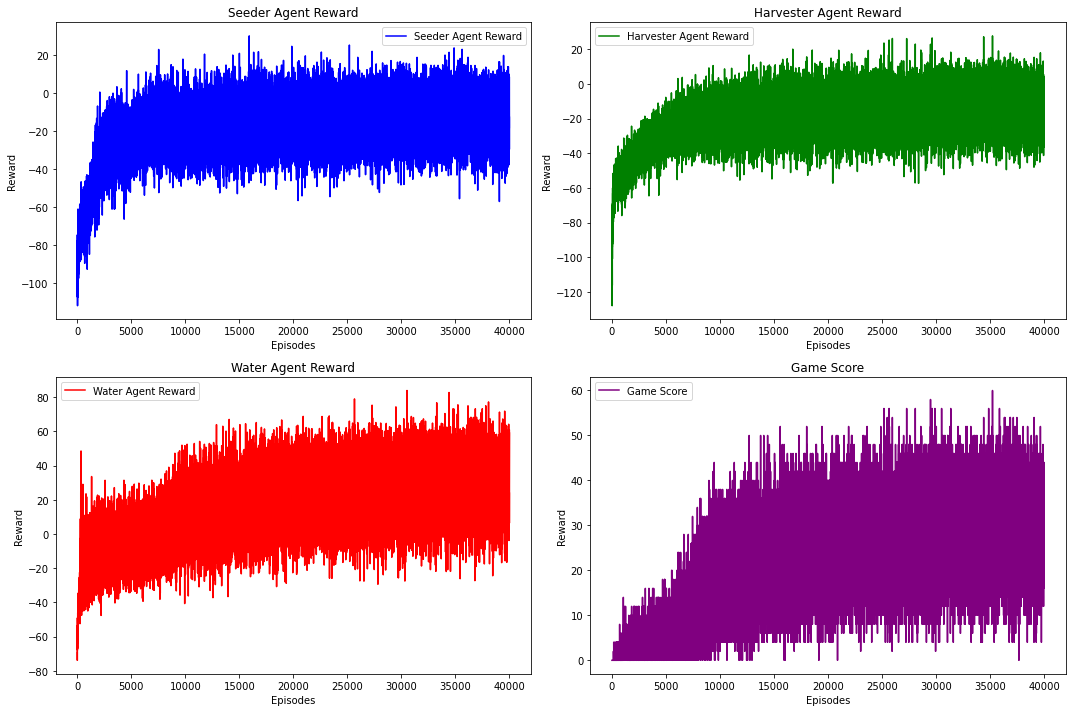

In [25]:
plot_rewards(seeder_rewards, water_rewards, harvester_rewards, game_scores)

In [ ]:
# Number of episodes for testing
test_episodes = 20
test_seeder_rewards = []
test_water_rewards = []
test_harvester_rewards = []
test_game_scores = []
# Flag to save videos during testing
save_video = False

with tqdm(total=test_episodes, desc="Testing Episodes", unit="episode") as pbar:
    for episode in range(test_episodes):
        
        if save_video:
            video_filename = f"a2c_5x4_3agents/test_episode_{episode+1}.mp4"
            # Initialize VideoWriter to write video frame
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            video_writer = None

        # Reset environment for AgriEnv
        state, _ = agri_env.reset()
        done = False
        episode_rewards_seeder = 0
        episode_rewards_harvester = 0
        episode_rewards_water = 0

        while not done:
            # Construct state for all agents
            seeder_state = state[0] + state[1]
            water_state = state[0] + state[2]
            harvester_state = state[0] + state[3]
            
            # Get actions for all agents
            seeder_action, _ = seeder_agent.get_action(seeder_state)
            water_action, _ = water_agent.get_action(water_state)
            harvester_action, _ = harvester_agent.get_action(harvester_state)

            # Take actions in the environment
            next_state, reward, done, _ = agri_env.step({
                'seeder_agent': seeder_action,
                'harvester_agent': harvester_action,
                'water_agent': water_action
            })

            if save_video:
                frame = agri_env.render()
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                if video_writer is None:
                    height, width, _ = frame.shape
                    video_writer = cv2.VideoWriter(video_filename, fourcc, 30, (width, height))
                video_writer.write(frame)

            # Update episode rewards
            episode_rewards_seeder += reward['seeder_agent']
            episode_rewards_water += reward['water_agent']
            episode_rewards_harvester += reward['harvester_agent']

            # Update state
            state = next_state

        if save_video and video_writer is not None:
            video_writer.release()
            print(f"Test video for episode {episode+1} saved as {video_filename}")

        # Store episode rewards
        test_seeder_rewards.append(episode_rewards_seeder)
        test_water_rewards.append(episode_rewards_water)
        test_harvester_rewards.append(episode_rewards_harvester)
        test_game_scores.append(agri_env.game_score)

        # Update progress bar
        pbar.set_postfix({
            'Seeder Reward': episode_rewards_seeder,
            'Water Reward': episode_rewards_water,
            'Harvester Reward': episode_rewards_harvester,
            'Game Score': agri_env.game_score
        })
        pbar.update(1)

# Summary of results
print("Testing Completed")
print(f"Average Seeder Reward: {sum(test_seeder_rewards) / test_episodes}")
print(f"Average Water Reward: {sum(test_water_rewards) / test_episodes}")
print(f"Average Harvester Reward: {sum(test_harvester_rewards) / test_episodes}")
print(f"Average Game Score: {sum(test_game_scores) / test_episodes}")
print(f"Highest Game Score: {max(test_game_scores)}")
print(f"Lowest Game Score: {min(test_game_scores)}")

Testing Episodes: 100%|██████████| 20/20 [00:51<00:00,  2.55s/episode, Seeder Reward=-17, Water Reward=-11.4, Harvester Reward=40.7, Game Score=34]  

Testing Completed
Average Seeder Reward: -9.543000000000001
Average Water Reward: -10.984499999999992
Average Harvester Reward: 38.77999999999996
Average Game Score: 32.5
Highest Game Score: 52
Lowest Game Score: 16.0


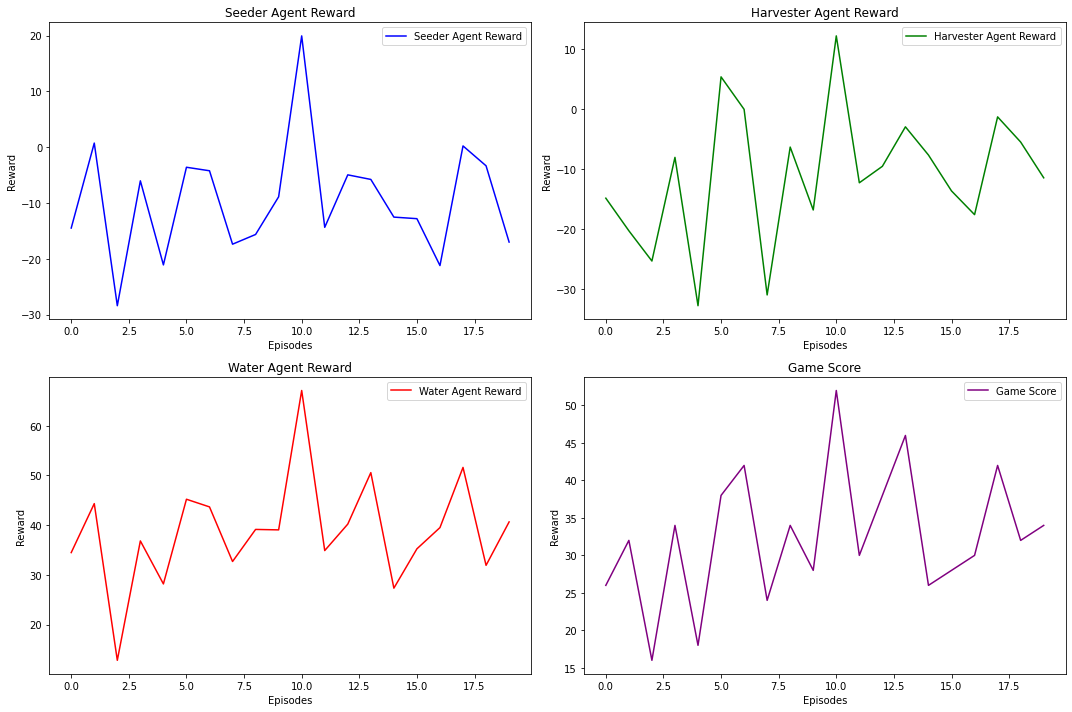

In [19]:
plot_rewards(test_seeder_rewards, test_water_rewards, test_harvester_rewards, test_game_scores)